<a href="https://colab.research.google.com/github/fsommers/ICMR24/blob/main/DistilBERT_classification_last_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Classification with DistilBERT
## Fine-Tuning only the Last Layers

This classification uses the text modality in documents only. To increase the training speed and to require less training resources, we freeze all but the last 2 model layers. In the case of DistilBERT, those are the pre-classifier and classifier layers.

In [1]:
!pip install -qqq pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.5 MB/s eta 0:00:00


After installing Lightning, restart the Colab session.

In [6]:
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive')

EXAMPLES_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'TRAINING')
UNSEEN_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'UNSEEN')
DATASET_DIR = Path(BASE_DIR / 'DOC_DATA')
LOG_DIR = Path(BASE_DIR / 'DOC_LOGS')
MODELS_DIR = Path(BASE_DIR / 'DOC_MODELS')


DOCUMENT_LABELS = [
    'AZCONTRACT',
    'BUYERSGUIDE',
    'CACONTRACT',
    'CREDITAPP',
    'NVCONTRACT',
    'BOOKSHEET',
    'INSURANCE'
]

# The assumption is that training documents are pre-categorized and collected into subdirectories,
# with directory names corresponding to the document class names
training_dirs = { doc_label: EXAMPLES_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(training_dirs)

unseen_dirs = { doc_label: UNSEEN_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(unseen_dirs)

# Keep a stable ordering of the class labels.
DOCUMENT_CLASSES = sorted(training_dirs.keys())
print(DOCUMENT_CLASSES)

selected_images = []
for p in training_dirs.values():
  imp = list(p.glob('*.jpg'))
  selected_images.extend(imp)
print(len(selected_images), 'files')

num_labels = len(DOCUMENT_CLASSES)
print('Labels: ', num_labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'AZCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/AZCONTRACT'), 'BUYERSGUIDE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BUYERSGUIDE'), 'CACONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CACONTRACT'), 'CREDITAPP': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CREDITAPP'), 'NVCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/NVCONTRACT'), 'BOOKSHEET': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BOOKSHEET'), 'INSURANCE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/INSURANCE')}
{'AZCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/AZCONTRACT'), 'BUYERSGUIDE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/BUYERSGUIDE'), 'CACONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/CACONTRACT'), 'CREDITAPP': PosixPath('/content/driv

In [3]:
from torch.utils.data import Dataset
import torch
import json

class DocumentClassificationForBertDataset(Dataset):

  def __init__(self, image_paths, tokenizer, max_length, document_classes):
    self.image_paths = image_paths
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.document_classes = document_classes

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image_path = self.image_paths[item]
    with image_path.with_suffix(".json").open("r") as f:
      ocr_data = json.load(f)
      words = ocr_data["words"]

    encoding = self.tokenizer(
      text=' '.join(words),
      max_length=self.max_length,
      truncation=True,
      padding="max_length",
      return_tensors="pt"
    )

    # The document file's parent directory name is the label for the file:
    label = self.document_classes.index(image_path.parent.name)

    return dict(
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        labels=torch.tensor(label, dtype=torch.long)
    )

In [ ]:
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader, random_split

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

dataset = DocumentClassificationForBertDataset(image_paths=selected_images, tokenizer=tokenizer, max_length=512, document_classes=DOCUMENT_CLASSES)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [5]:
for item in train_dataset:
  tokens = tokenizer.convert_ids_to_tokens(item['input_ids'])
  print(tokens)
  print(tokenizer.convert_tokens_to_string(tokens))
  print(item['labels'].item())
  break

['[CLS]', '1', '##c', '##4', '##pu', '##md', '##n', '##1', '##k', '##d', '##20', '##9', '##26', '##6', '—', 'yes', 'yes', 'vin', ':', 'year', ':', '2019', 'yer', 'make', ':', 'jeep', 'yes', 'model', ':', 'cherokee', 'yes', 'trim', ':', 'utility', '4', '##b', 'limited', '4', '##wd', '2', '.', '0', '##l', '##14', 'tu', '##r', '##8', '##o', '—', '™', '##m', 'tal', '0', 'x', '{', 'es', 'miles', ':', '93', ',', '42', '##4', 'yer', 'transmission', ':', 'engine', ':', 'drive', '##train', ':', 'color', ':', '£', 'lace', 'value', 'wo', 'mile', '##age', ':', '$', '19', ',', '625', 'mile', '##age', 'ad', '##j', '.', ':', '$', '-', '1', ',', '450', 'blue', 'book', 'value', ':', '$', '16', ',', '175', '—', 'clean', 'value', 'date', ':', '04', '-', '02', '-', '202', '##4', 'options', ':', '[', ']', '|', 'certified', 'pre', '-', 'owned', ']', 'ada', '##p', 'ti', '##ve', 'cruise', 'control', '$', '125', '.', '00', '{', 'x', ']', 'power', 'drivers', 'seat', '|', '|', 'luggage', 'rack', '$', '50', '.', 

In [50]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [39]:
# Freeze all params
for param in model.parameters():
  param.requires_grad = False

# Unfreeze lsat 2 layers:
for param in model.pre_classifier.parameters():
  param.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True

In [51]:
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.optim import AdamW
from transformers import DistilBertForSequenceClassification

class DistilBertLightningModule(pl.LightningModule):
  def __init__(self, model, lr=2e-5):
    super().__init__()
    self.model = model
    self.lr = lr
    self.save_hyperparameters(ignore=['model'])

  def forward(self, input_ids, attention_mask, labels=None):
    return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

  def training_step(self, batch, batch_idx):
    output = self(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['labels']
    )
    self.log('train_loss', output.loss)
    return output.loss

  def validation_step(self, batch, batch_idx):
    output = self(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['labels']
    )
    self.log('val_loss', output.loss)
    return output.loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.lr)

lightning_model = DistilBertLightningModule(model)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=11, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=11)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='distilbert-{epoch}-{step}-{val_loss:.4f}'
)

trainer = pl.Trainer(
    default_root_dir=MODELS_DIR,
    accelerator='gpu',
    devices=1,
    max_epochs=3,
    callbacks=[
      checkpoint_callback
    ]
)

In [42]:
trainer.fit(lightning_model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                                | Params
--------------------------------------------------------------
0 | model | DistilBertForSequenceClassification | 67.0 M
--------------------------------------------------------------
595 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.835   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [43]:
checkpoint_callback.best_k_models

{'/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_37/checkpoints/distilbert-epoch=0-step=175-val_loss=1.6596.ckpt': tensor(1.6596, device='cuda:0'),
 '/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_37/checkpoints/distilbert-epoch=1-step=350-val_loss=1.3769.ckpt': tensor(1.3769, device='cuda:0'),
 '/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_37/checkpoints/distilbert-epoch=2-step=525-val_loss=1.1177.ckpt': tensor(1.1177, device='cuda:0')}

In [44]:
trained_model = DistilBertLightningModule.load_from_checkpoint(
    Path(MODELS_DIR / "lightning_logs/version_37/checkpoints/distilbert-epoch=2-step=525-val_loss=1.1177.ckpt"))

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
trained_model.eval().to(DEVICE)

In [46]:
def predict(image_path):
  with image_path.with_suffix(".json").open("r") as f:
    ocr_data = json.load(f)
    words = ocr_data["words"]

  encoding = tokenizer(
      text=' '.join(words),
      max_length=512,
      truncation=True,
      padding="max_length",
      return_tensors="pt"
    )
  with torch.no_grad():
    output = model(
        input_ids=encoding['input_ids'],
        attention_mask=encoding['attention_mask']
    )
  prediction = torch.argmax(output.logits, dim=1)
  item = prediction.item()
  return DOCUMENT_CLASSES[item]

In [47]:
test_image = list(unseen_dirs['AZCONTRACT'].glob('*.jpg'))[2]
predicted = predict(test_image)
print(f"Predicted class: {predicted}")

Predicted class: AZCONTRACT


In [48]:
from tqdm import tqdm

labels = []
images = []
predictions = []
for lab, dir in unseen_dirs.items():
  ims = list(dir.glob('*.jpg'))
  for f in ims:
    labels.append(lab)
    images.append(f)

for image_path in tqdm(images):
  pred = predict(image_path)
  predictions.append(pred)

100%|██████████| 700/700 [11:39<00:00,  1.00it/s]


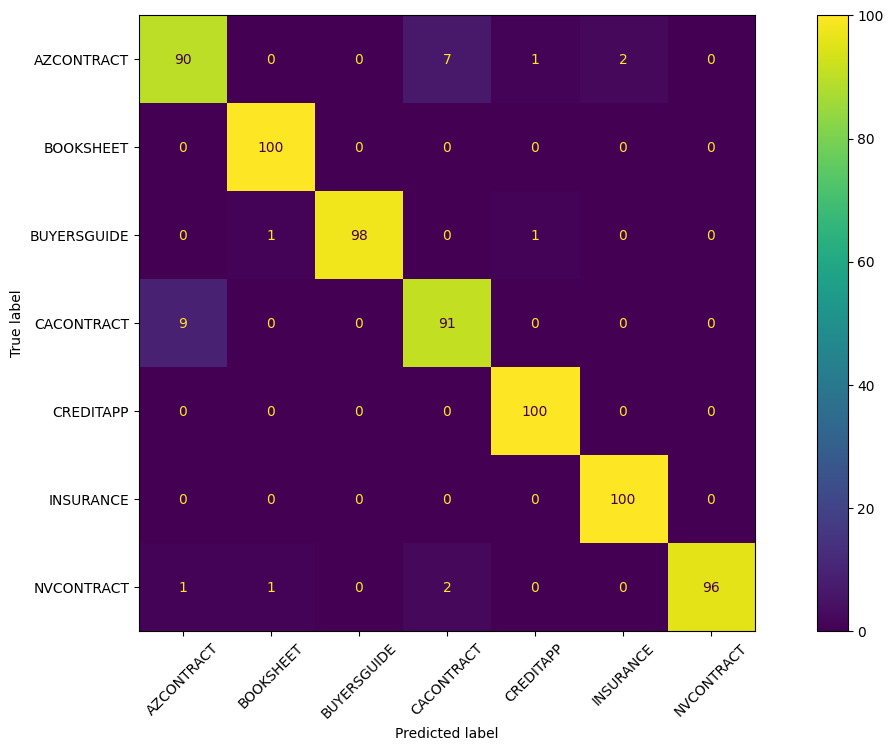

In [49]:
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels=DOCUMENT_CLASSES,
)
cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)

plt.show()